## Water Demand Tutorial

In [1]:
#%matplotlib inline

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import folium
import scipy
import seaborn as sns
from sentinelsat import SentinelAPI, make_path_filter
from IPython import display
import shapely
from shapely.geometry import MultiPolygon
import add_axis_scalebar as add_axis_elements
from csv_merge import merge_csv_to_wrz
import download_sat_image_company
from IPython.display import Image
from chloropleth import chloropleth_pcc

True


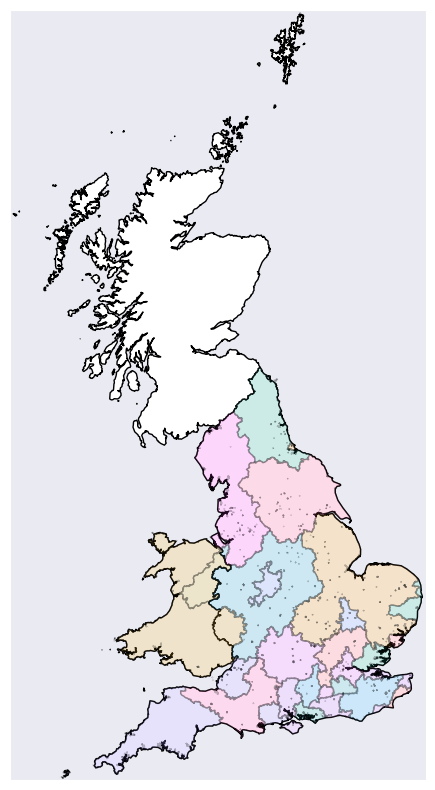

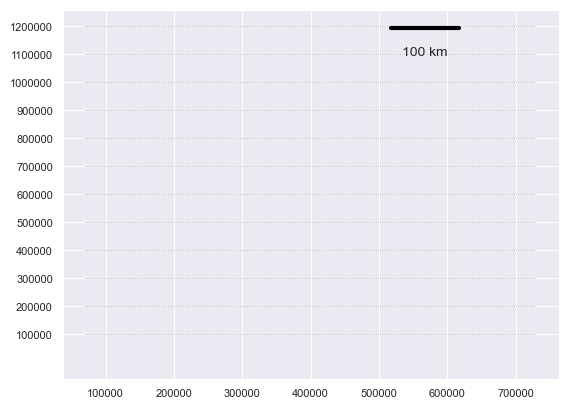

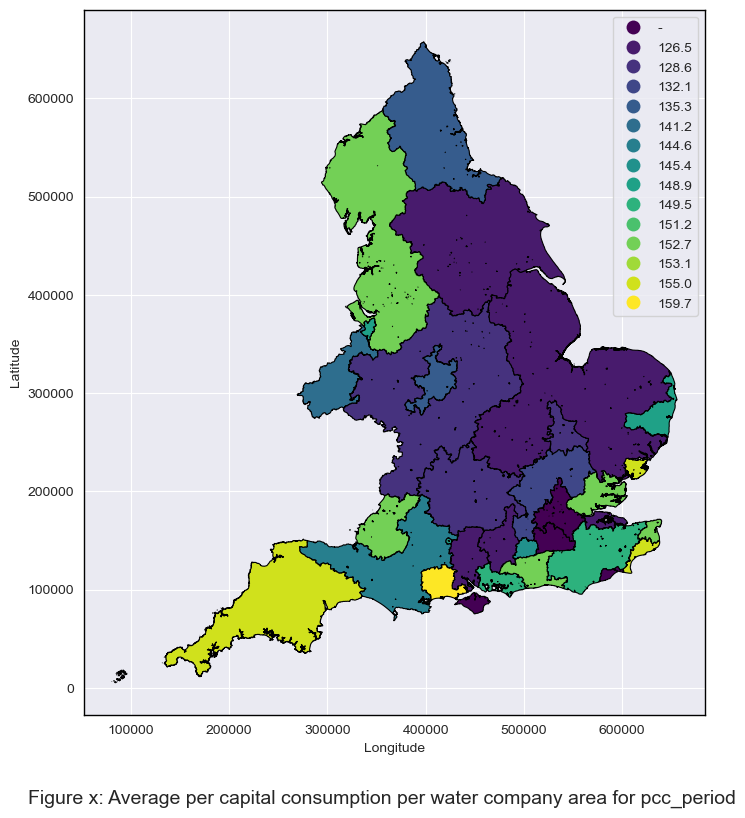

In [2]:
pcc_period ='2019-20'
chloropleth_pcc(pcc_period)

In [ ]:


# Set Seaborn style and color palette
sns.set_style("darkgrid")
sns.set_palette("husl")

# generate matplotlib handles to create a legend of the features to put in the map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '20 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-12500, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=8)

In [ ]:
# load the outline of UK for a backdrop
outline = gpd.read_file(os.path.abspath('data_files/Outline.shp'))

In [ ]:
# Load water company data as wrz, remove unnecessary columns
wrz = gpd.read_file(os.path.abspath('data_files/WaterSupplyAreas_incNAVs v1_4.shp'))
# List of columns to be removed
columns_to_remove = ['Disclaimer', 'Disclaim2', 'Disclaim3', 'Provenance', 'Licence', 'WARNINGS', 'Revisions']

# Drop the columns from the GeoDataFrame
wrz = wrz.drop(columns=columns_to_remove)

In [ ]:
# wrz.head(10)

In [ ]:
myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

myCRS = ccrs.TransverseMercator(27700)  # create a Universal Transverse Mercator reference system to transform our data.

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

In [ ]:
# first, we just add the outline using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature) # add the features we've created to the map.

In [ ]:
# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS) # because total_bounds 
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

#myFig ## re-draw the figure

In [ ]:
# get the number of unique water companies we have in the dataset
num_wrz = len(wrz.COMPANY.unique())
# print('Number of unique features: {}'.format(num_wrz))

In [ ]:
# pick colours for the individual water companies- generate random RGB colors
num_colours = num_wrz  # Number of colours to generate
company_colours = sns.color_palette("husl", n_colors=num_colours)  # Use Seaborn color palette

In [ ]:
# get a list of unique names for the company boundaries
company_names = list(wrz.COMPANY.unique())
company_names.sort() # sort the companies alphabetically by name

In [ ]:
# next, add the company outlines to the map using the colours that we've picked.
for ii, name in enumerate(company_names):
    feat = ShapelyFeature(wrz.loc[wrz['COMPANY'] == name, 'geometry'], # first argument is the geometry
                          myCRS, # second argument is the CRS
                          edgecolor='k', # outline the feature in black
                          facecolor=company_colours[ii], # set the face color to the corresponding color from the list
                          linewidth=1, # set the outline width to be 1 pt
                          alpha=0.25) # set the alpha (transparency) to be 0.25 (out of 1)
    ax.add_feature(feat) # once we have created the feature, we have to add it to the map using ax.add_feature()

In [ ]:
# myFig # to show the updated figure

In [ ]:
fig, ax = plt.subplots() # ... code to create the plot ...
add_axis_elements.add_axis_elements(ax)
# plt.show()

In [ ]:
# this is where I am at - need to remove code below as I have created a function module

In [ ]:
print(wrz.crs == outline.crs) # test if the crs is the same 

In [ ]:
#wrz.loc[1] # to view the first row of the geodataframe

In [ ]:
##tried to get this function module to work but no luck...
#merge_csv_to_wrz('data_files/pr24_hist_pcc.csv', '2019-20')
#wrz

In [ ]:
# Append PCC for 2019 to 2020 to the wrz geodataframe

# Load the CSV file
pr24_hist_pcc = pd.read_csv('data_files/pr24_hist_pcc.csv') 


# Perform the merge
merged = wrz.merge(pr24_hist_pcc[['Company', '2019-20']], how='left', left_on='Acronym', right_on='Company')

# Drop the unnecessary columns & rename the merged column
merged.drop(['Company'], axis=1, inplace=True)
merged.rename(columns={'2019-20': '2019-20_from_CSV'}, inplace=True)

# Update the wrz GeoDataFrame with the merged column
wrz['2019-20'] = merged['2019-20_from_CSV']


In [ ]:
#Add chloropleth map
# Create the chloropleth map
wrz.plot(column='2019-20', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True, figsize=(10, 10))

# Set plot title at the bottom of the map
plt.suptitle('Figure x: Average per capital consumption per water company area for 2019-20', y=0.1, fontsize=14)

# Add a border around the map
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)
    
# Set plot title and axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the spacing between the title and the axis labels
plt.subplots_adjust(bottom=0.175)

# Show the plot
# plt.show()
# Save the plot as a JPEG file
plt.savefig('data_files/2019_20_pcc.jpg', dpi=300)

In [ ]:
#wrz.loc[1]

In [ ]:
# Append PCC for 2011 to 2012 to the wrz geodataframe
# Load the GeoDataFrame
# wrz = gpd.read_file(os.path.abspath('data_files/WaterSupplyAreas_incNAVs v1_4.shp'))  

# Load the CSV file
pr24_hist_pcc = pd.read_csv('data_files/pr24_hist_pcc.csv') 

# Perform the merge
merged = wrz.merge(pr24_hist_pcc[['Company', '2011-12']], how='left', left_on='Acronym', right_on='Company')

# Drop the unnecessary columns
merged.drop(['Company'], axis=1, inplace=True)

# Rename the merged column
merged.rename(columns={'2011-12': '2011-12_from_CSV'}, inplace=True)

# Update the wrz GeoDataFrame with the merged column
wrz['2011-12'] = merged['2011-12_from_CSV']

# Update the wrz GeoDataFrame with the merged column
wrz['2011-12'] = merged['2011-12_from_CSV']

# Check the updated GeoDataFrame for 2011-2012 water company data
#wrz.loc[1]

In [ ]:
# Create the chloropleth map
wrz.plot(column='2011-12', cmap='viridis', linewidth=0.8, edgecolor='black', legend=True, legend_kwds={'title': 'PCC in litres per day'}, figsize=(10, 10))

# Set plot axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add a border around the map
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.suptitle('Figure x: Average per capital consumption per water company area for 2011-12', y=0.1, fontsize=14) # Set plot title at the bottom of the map

plt.subplots_adjust(bottom=0.175) # Adjust the spacing between the title and the axis labels

#plt.show() # Show the plot
plt.savefig('data_files/2011_12_pcc.jpg', dpi=300) # Save the plot as a JPEG file

In [ ]:
#- legend_kwds={'caption': 'Per Capita Water Consumption'} # set the caption to a longer explanation

In [ ]:
# Create a Folium map using the existing GeoDataFrame
m = folium.Map()

m = wrz.explore('2019-20', # show the PCC for this period column
                   cmap='viridis', # use the 'plasma' colormap from matplotlib
                   legend_kwds={'caption': 'PCC for 2019-20'} # set the caption to a longer explanation
                  )

watercompany_args = {
    'm': m, # add the markers to the same map we just created
    'marker_type': 'marker', # use a marker for the points, instead of a circle
    'popup': True, # show the information as a popup when we click on the marker
    'legend': False, # don't show a separate legend for the point layer
    'marker_kwds': {'icon': folium.Icon(color='red', icon='dot', prefix='fa')} # make the markers red with a dot icon from FA
}
m
# Save the map to a png file
m.save('data_files/pcc_popups.png')

In [ ]:
# install sentinelsat via conda; set up netrc file for api

In [ ]:
# select water company to review in further detail:
company_detail ='Bournemouth'
download_sat_image_company.download_best_overlap_image(company_detail)
Image(filename='data_files/img.png')

In [ ]:
To download the images, edit the download_sat_image_company module to uncomment the line to enable download. 